In [147]:
import matplotlib.pyplot as plt 
import xarray as xr 
import numpy as np 
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cartopyFeature
import pandas as pd

In [20]:
import sys
import os

In [4]:
sys.path.append("../scripts")

In [5]:
import casos

In [7]:
base_case_dir = casos.base_config["base_case_directory"] 

In [270]:
prcp = list(filter(lambda c: c["case_name"].endswith("TNA_MJJ") , casos.cases ))

In [271]:
prcp

[{'case_name': 'pycpt_GTM_EPS_TNA_MJJ',
  'MOS': 'CCA',
  'predictor_names': ['CCSM4.SST',
   'CanSIPSIC3.SST',
   'GEOSS2S.SST',
   'SPEAR.SST',
   'CFSv2.SST',
   'SEAS5.SST',
   'METEOFRANCE8.SST',
   'GLOSEA6.SST'],
  'download_args': {'fdate': datetime.datetime(2023, 4, 1, 0, 0),
   'target': 'May-Jul',
   'predictor_extent': {'east': -15, 'west': -55, 'north': 25, 'south': 5}}}]

In [272]:
def get_case_outputs(case):
    domain = case["download_args"]['predictor_extent']
    e,w,n,s = domain.values()
    domain = f"{w}W-{e}E_to_{s}S-{n}N"

    casedir = f"{base_case_dir}/{case['case_name']}/{domain}"
    outputdir = f"{casedir}/output"
    outputs = os.listdir(outputdir)
    skills = {}
    
    for filename in filter(lambda item: "skillscores_cca.nc" in item, outputs):
        model = filename.split(".")[0]
        print(f"Loading data file {filename}")
        skills[model] = xr.open_dataset(f"{outputdir}/{filename}")
    return skills

In [273]:
prcp_outputs = get_case_outputs(prcp[0])

Loading data file CanSIPSIC3.SST_skillscores_cca.nc
Loading data file SPEAR.SST_skillscores_cca.nc
Loading data file CFSv2.SST_skillscores_cca.nc
Loading data file SEAS5.SST_skillscores_cca.nc
Loading data file CCSM4.SST_skillscores_cca.nc
Loading data file GEOSS2S.SST_skillscores_cca.nc
Loading data file GLOSEA6.SST_skillscores_cca.nc


In [274]:
prcp_outputs.keys()

dict_keys(['CanSIPSIC3', 'SPEAR', 'CFSv2', 'SEAS5', 'CCSM4', 'GEOSS2S', 'GLOSEA6'])

Text(0.5, 1.0, 'CanSIPSIC3')

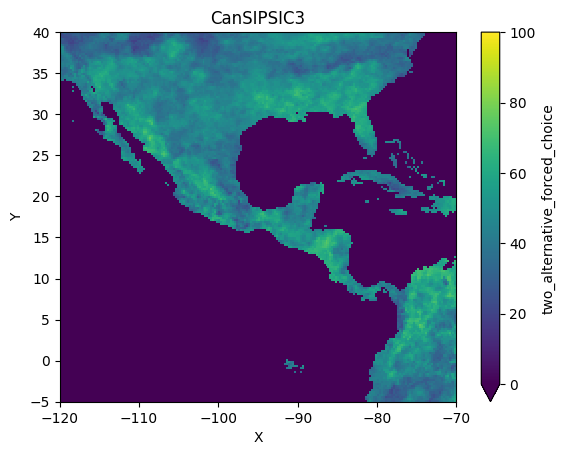

In [275]:
prcp_outputs["CanSIPSIC3"].two_alternative_forced_choice.plot(vmin=0, vmax=100)
plt.title("CanSIPSIC3")

In [276]:
tafc = prcp_outputs["CanSIPSIC3"].two_alternative_forced_choice

Text(0.5, 0.98, 'Sur')

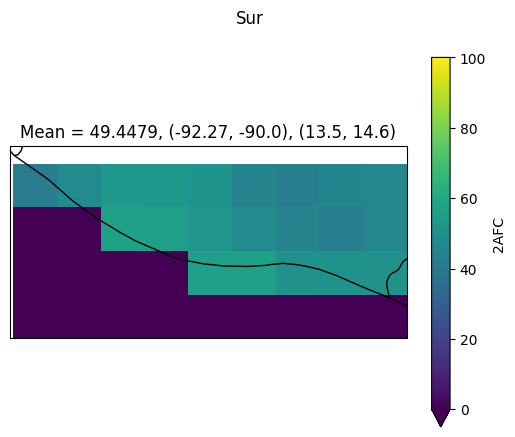

In [277]:
x0, x1 = -92.27, -90.0
y0, y1 = 13.5, 14.6
area_sur = (x0, x1, y0, y1)
ax = plt.subplot(1,1,1, projection = ccrs.PlateCarree())
tafc.where((tafc.Y>y0) & (tafc.Y<y1) & (tafc.X>x0) & (tafc.X<x1)).plot(ax=ax, vmin=0, vmax=100, cbar_kwargs={'label':"2AFC"})
plt.xlim(x0,x1)
plt.ylim(y0,y1)
ax.coastlines()
ax.add_feature(cartopyFeature.BORDERS)
mean = tafc.where((tafc.Y>y0) & (tafc.Y<y1) & (tafc.X>x0) & (tafc.X<x1) & (tafc>=0) ).mean()
plt.title(f"Mean = {mean:.4f}, {x0,x1}, {y0,y1}")
plt.suptitle("Sur")

Text(0.5, 0.98, 'Central')

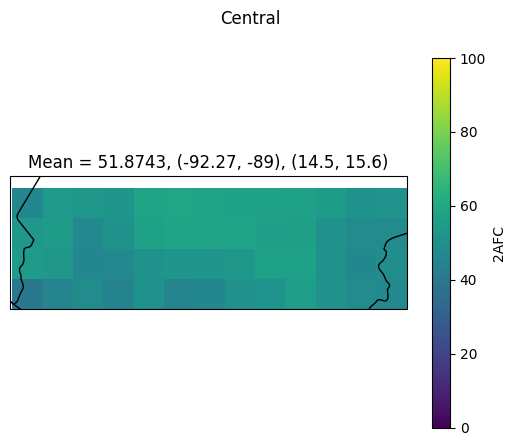

In [278]:
x0, x1 = -92.27, -89
y0, y1 = 14.5, 15.6
area_central = (x0, x1, y0, y1)
ax = plt.subplot(1,1,1, projection = ccrs.PlateCarree())
tafc.where((tafc.Y>y0) & (tafc.Y<y1) & (tafc.X>x0) & (tafc.X<x1)).plot(ax=ax, vmin=0, vmax=100, cbar_kwargs={'label':"2AFC"})
plt.xlim(x0,x1)
plt.ylim(y0,y1)
ax.coastlines()
ax.add_feature(cartopyFeature.BORDERS)
mean = tafc.where((tafc.Y>y0) & (tafc.Y<y1) & (tafc.X>x0) & (tafc.X<x1) & (tafc>=0) ).mean()
plt.title(f"Mean = {mean:.4f}, {x0,x1}, {y0,y1}")
plt.suptitle("Central")

Text(0.5, 0.98, 'Norte')

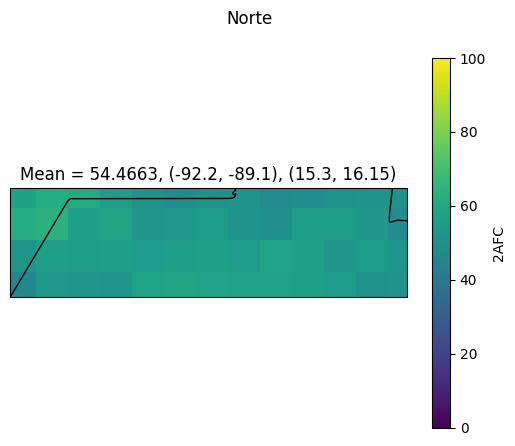

In [279]:
x0, x1 = -92.2, -89.1
y0, y1 = 15.3, 16.15
area_norte = (x0, x1, y0, y1)
ax = plt.subplot(1,1,1, projection = ccrs.PlateCarree())
tafc.where((tafc.Y>y0) & (tafc.Y<y1) & (tafc.X>x0) & (tafc.X<x1)).plot(ax=ax, vmin=0, vmax=100, cbar_kwargs={'label':"2AFC"})
plt.xlim(x0,x1)
plt.ylim(y0,y1)
ax.coastlines()
ax.add_feature(cartopyFeature.BORDERS)
mean = tafc.where((tafc.Y>y0) & (tafc.Y<y1) & (tafc.X>x0) & (tafc.X<x1) & (tafc>=0) ).mean()
plt.title(f"Mean = {mean:.4f}, {x0,x1}, {y0,y1}")
plt.suptitle("Norte")

In [288]:
aggregates = []
areas = {'sur': area_sur, 'central': area_central, 'norte': area_norte}
for case in casos.cases: 
    outputs = get_case_outputs(case)
    print("Reading", case["case_name"])
    for key,value in outputs.items():
        for keyarea, area in areas.items():
            x0, x1, y0, y1 = area
            for variable in list(value.variables.keys()):
                if variable in ["X", "Y"]: continue
                data = getattr(value, variable)
                mean = data.where((data.Y>y0) & (data.Y<y1) & (data.X>x0) & (data.X<x1) & (data>= -100) ).mean()
                std = data.where((data.Y>y0) & (data.Y<y1) & (data.X>x0) & (data.X<x1) & (data>= -100) ).std()
                aggregates.append([
                    case["case_name"], key, keyarea, variable, mean.values+0, std.values + 0
                ])

Loading data file SEAS5.UA_skillscores_cca.nc
Loading data file CanSIPSIC3.UA_skillscores_cca.nc
Reading pycpt_GTM_EPS_UA_MJJ
Loading data file METEOFRANCE8.UA_skillscores_cca.nc
Loading data file SEAS5.UA_skillscores_cca.nc
Loading data file CanSIPSIC3.UA_skillscores_cca.nc
Reading pycpt_GTM_EPS_UA_JJA
Loading data file METEOFRANCE8.UA_skillscores_cca.nc
Loading data file SEAS5.UA_skillscores_cca.nc
Loading data file CanSIPSIC3.UA_skillscores_cca.nc
Reading pycpt_GTM_EPS_UA_JAS
Loading data file CanSIPSIC3.SST_skillscores_cca.nc
Loading data file SPEAR.SST_skillscores_cca.nc
Loading data file CFSv2.SST_skillscores_cca.nc
Loading data file SEAS5.SST_skillscores_cca.nc
Loading data file CCSM4.SST_skillscores_cca.nc
Loading data file GEOSS2S.SST_skillscores_cca.nc
Loading data file GLOSEA6.SST_skillscores_cca.nc
Reading pycpt_GTM_EPS_NIÑO_MJJ
Loading data file CanSIPSIC3.SST_skillscores_cca.nc
Loading data file SPEAR.SST_skillscores_cca.nc
Loading data file CFSv2.SST_skillscores_cca.nc
L

In [334]:
aggregates[10:20]

[['pycpt_GTM_EPS_UA_MJJ',
  'SEAS5',
  'norte',
  'pearson',
  0.38247044230769234,
  0.22272137829242492],
 ['pycpt_GTM_EPS_UA_MJJ',
  'SEAS5',
  'norte',
  'spearman',
  0.4544147115384615,
  0.1825644663788801],
 ['pycpt_GTM_EPS_UA_MJJ',
  'SEAS5',
  'norte',
  'two_alternative_forced_choice',
  66.74331098076922,
  6.310982259558097],
 ['pycpt_GTM_EPS_UA_MJJ',
  'SEAS5',
  'norte',
  'roc_area_below_normal',
  0.759211326923077,
  0.11706945066345498],
 ['pycpt_GTM_EPS_UA_MJJ',
  'SEAS5',
  'norte',
  'roc_area_above_normal',
  0.6741824807692308,
  0.09102054651127496],
 ['pycpt_GTM_EPS_UA_MJJ',
  'CanSIPSIC3',
  'sur',
  'pearson',
  0.4802714285714285,
  0.06622129260835284],
 ['pycpt_GTM_EPS_UA_MJJ',
  'CanSIPSIC3',
  'sur',
  'spearman',
  0.5407040476190476,
  0.08447632163454143],
 ['pycpt_GTM_EPS_UA_MJJ',
  'CanSIPSIC3',
  'sur',
  'two_alternative_forced_choice',
  68.66804695238096,
  3.132028338732136],
 ['pycpt_GTM_EPS_UA_MJJ',
  'CanSIPSIC3',
  'sur',
  'roc_area_below

In [290]:
dfaggs = pd.DataFrame(aggregates, columns=["case", "model", "area", "variable", "mean", "std"])

In [292]:
dfaggs["periodo"] = dfaggs.case.map(lambda c: c[-3:])

In [294]:
dfaggs["predictor"] = dfaggs.case.map(lambda c: c.split("_")[-2])

In [295]:
dfaggs

,case,model,area,variable,mean,std,periodo,predictor
0,pycpt_GTM_EPS_UA_MJJ,SEAS5,sur,pearson,0.445248,0.077428,MJJ,UA
1,pycpt_GTM_EPS_UA_MJJ,SEAS5,sur,spearman,0.498054,0.087986,MJJ,UA
2,pycpt_GTM_EPS_UA_MJJ,SEAS5,sur,two_alternative_forced_choice,66.787440,3.368059,MJJ,UA
3,pycpt_GTM_EPS_UA_MJJ,SEAS5,sur,roc_area_below_normal,0.745855,0.061474,MJJ,UA
4,pycpt_GTM_EPS_UA_MJJ,SEAS5,sur,roc_area_above_normal,0.724310,0.068168,MJJ,UA
...,...,...,...,...,...,...,...,...
1150,pycpt_GTM_EPS_PRCP_JAS,CCSM4,norte,pearson,0.394234,0.197462,JAS,PRCP
1151,pycpt_GTM_EPS_PRCP_JAS,CCSM4,norte,spearman,0.423361,0.146928,JAS,PRCP
1152,pycpt_GTM_EPS_PRCP_JAS,CCSM4,norte,two_alternative_forced_choice,65.739967,5.556248,JAS,PRCP
1153,pycpt_GTM_EPS_PRCP_JAS,CCSM4,norte,roc_area_below_normal,0.680492,0.116199,JAS,PRCP


In [332]:
dfaggs[(dfaggs.area=="sur") & (dfaggs.periodo=="MJJ")].model.unique()

array(['SEAS5', 'CanSIPSIC3', 'SPEAR', 'CFSv2', 'CCSM4', 'GEOSS2S',
       'GLOSEA6'], dtype=object)

# Sur, MJJ

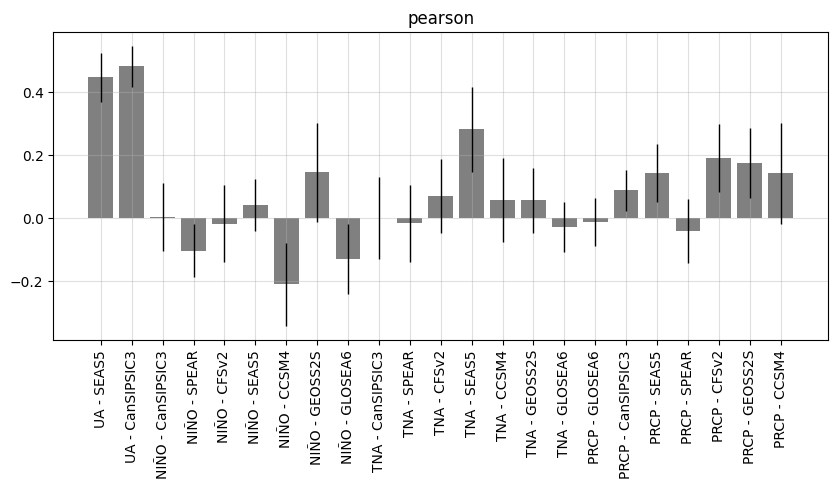

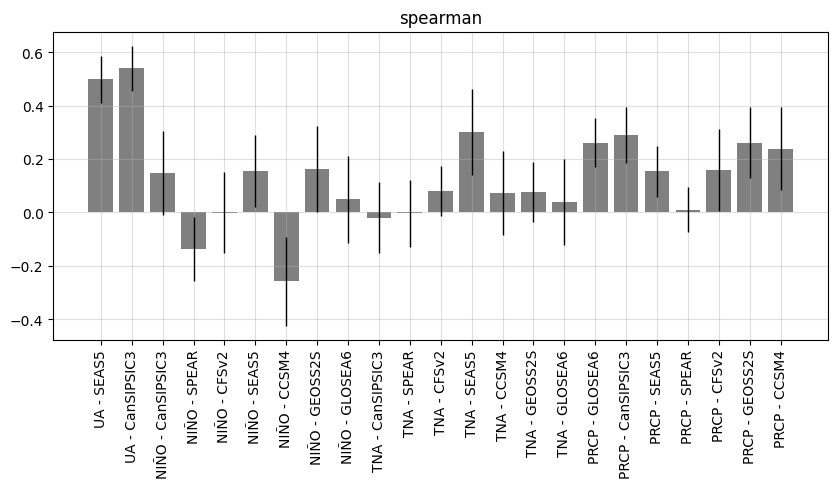

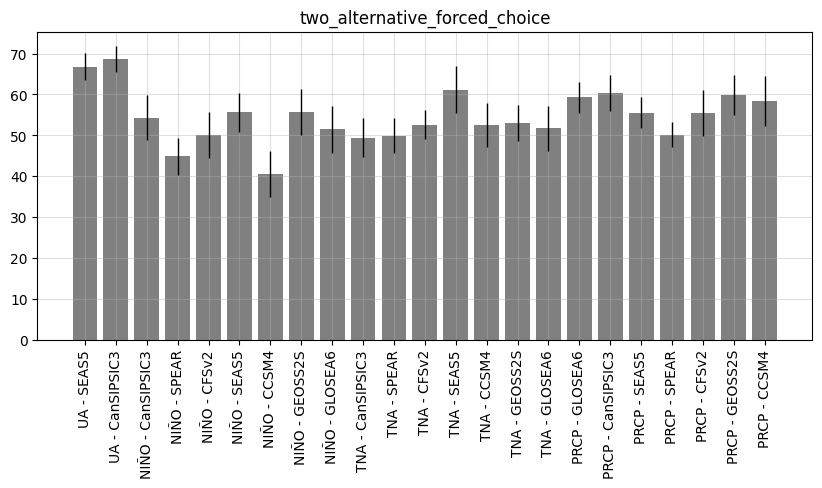

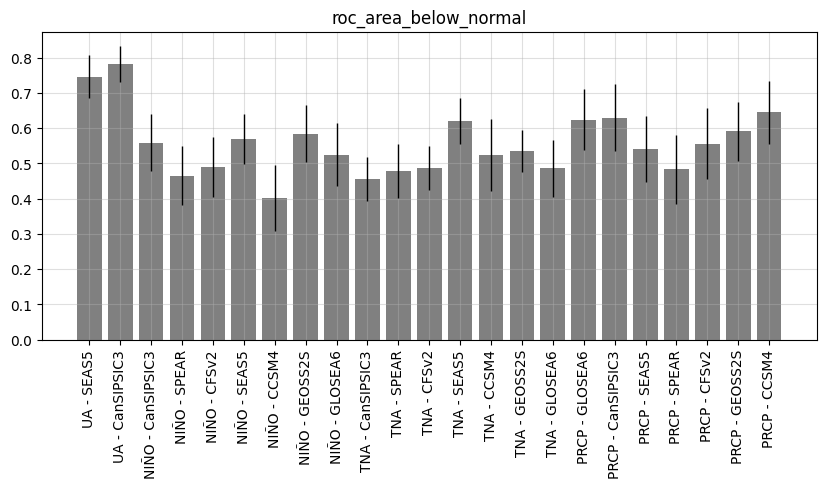

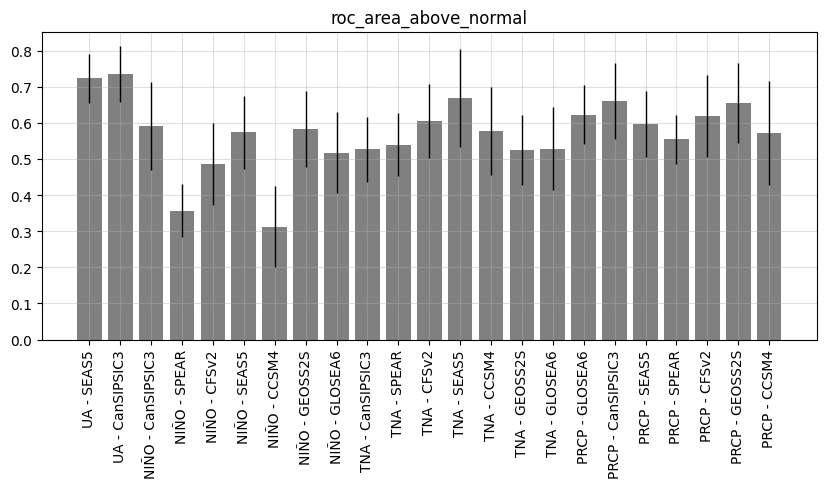

In [336]:
surmjj = dfaggs[(dfaggs.area=="sur") & (dfaggs.periodo=="MJJ")]
for variable in surmjj.variable.unique():
    subdata = surmjj[surmjj.variable == variable]
    xs = (np.arange(0, len(subdata), 1))
    fig = plt.figure(figsize=(10,4))
    plt.title(variable)
    plt.errorbar(xs, subdata["mean"], subdata["std"], lw=1, ls="", color="black")
    plt.bar(xs, subdata["mean"], color="gray")
    plt.xticks(xs, subdata.apply(lambda c: f"{c.predictor} - {c.model}", axis=1), rotation=90 )
    plt.grid(alpha=0.4)

# Central, MJJ

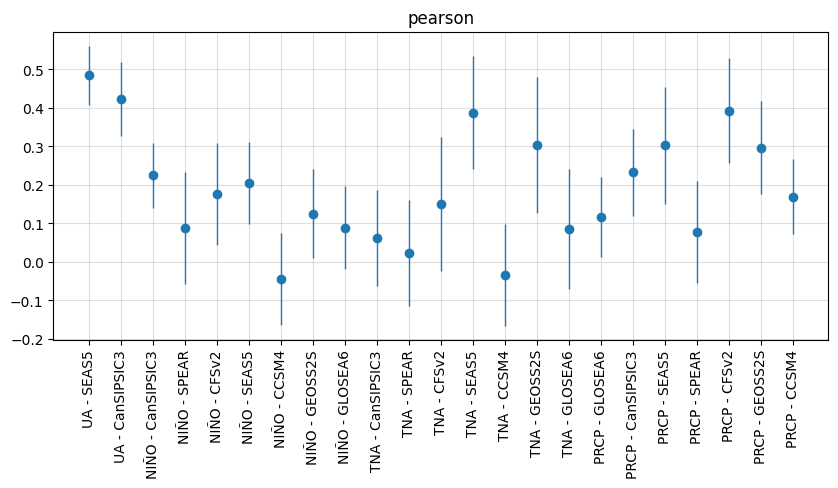

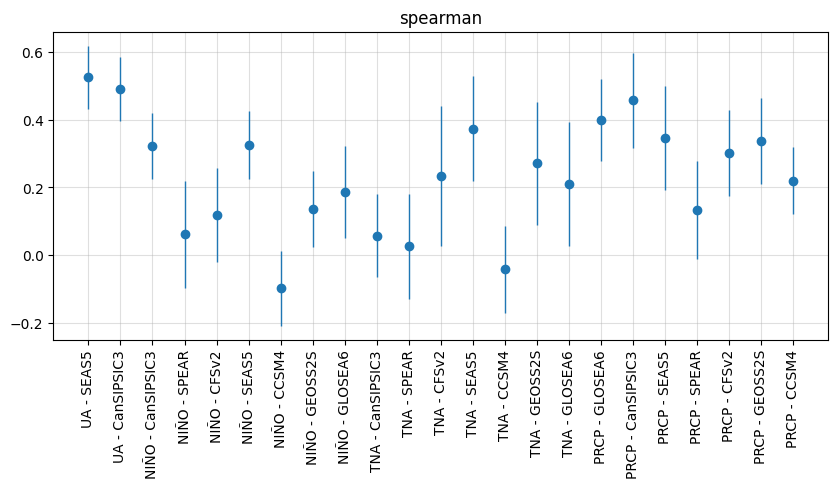

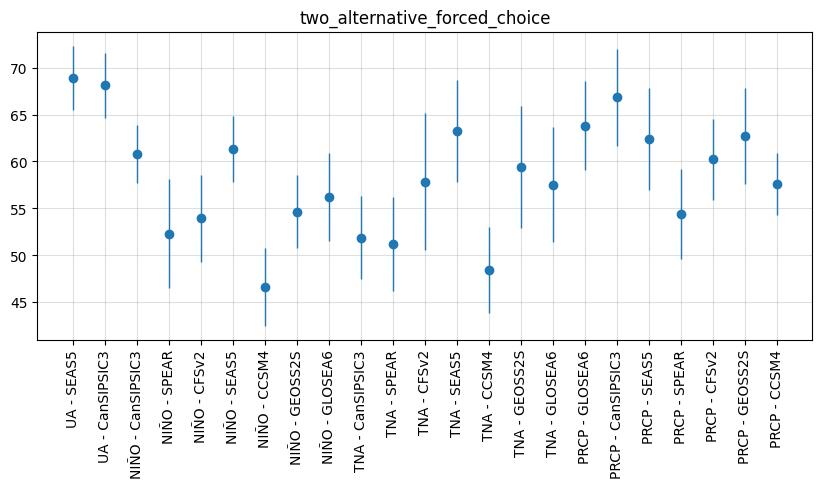

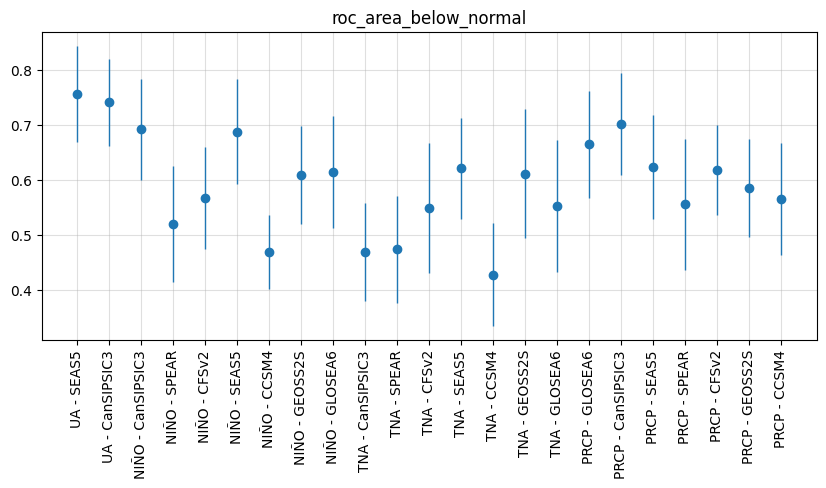

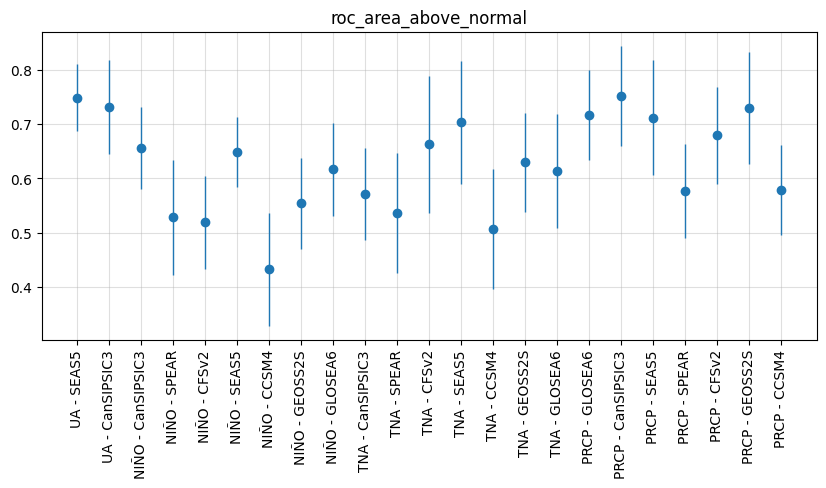

In [323]:
surmjj = dfaggs[(dfaggs.area=="central") & (dfaggs.periodo=="MJJ")]
for variable in surmjj.variable.unique():
    subdata = surmjj[surmjj.variable == variable]
    xs = (np.arange(0, len(subdata), 1))
    
    fig = plt.figure(figsize=(10,4))
    plt.title(variable)
    plt.errorbar(xs, subdata["mean"], subdata["std"], lw=1, ls="", marker="o")
    plt.xticks(xs, subdata.apply(lambda c: f"{c.predictor} - {c.model}", axis=1), rotation=90 )
    plt.grid(alpha=0.4)

# Norte, MJJ

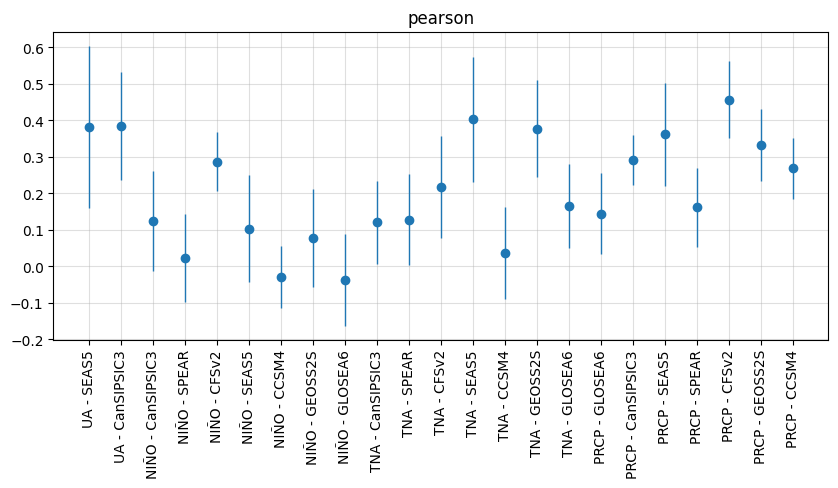

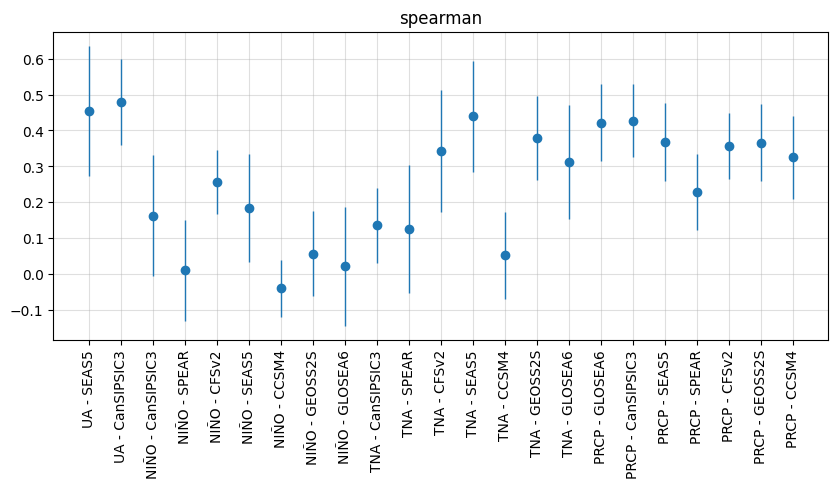

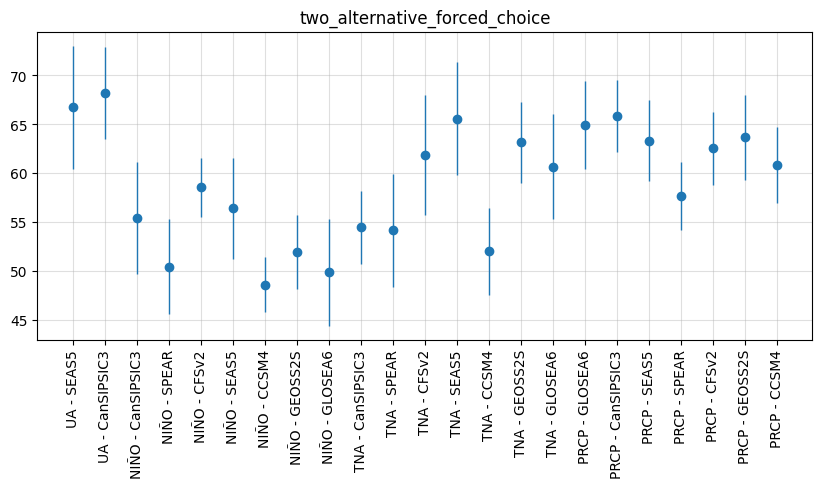

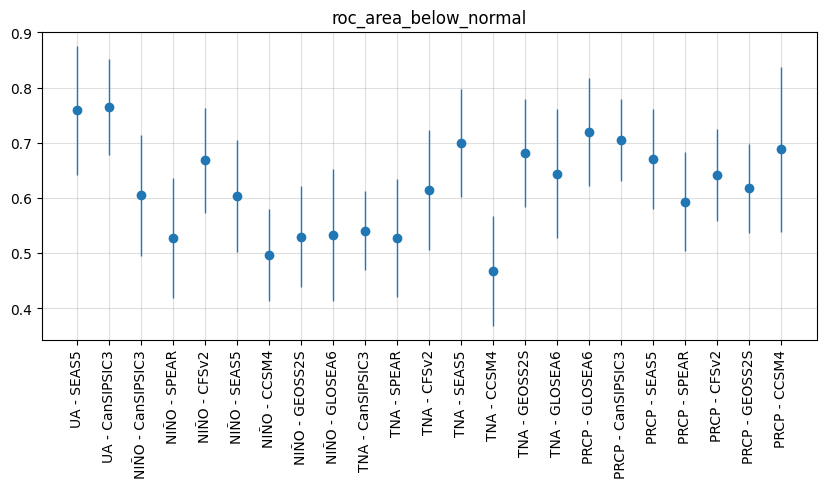

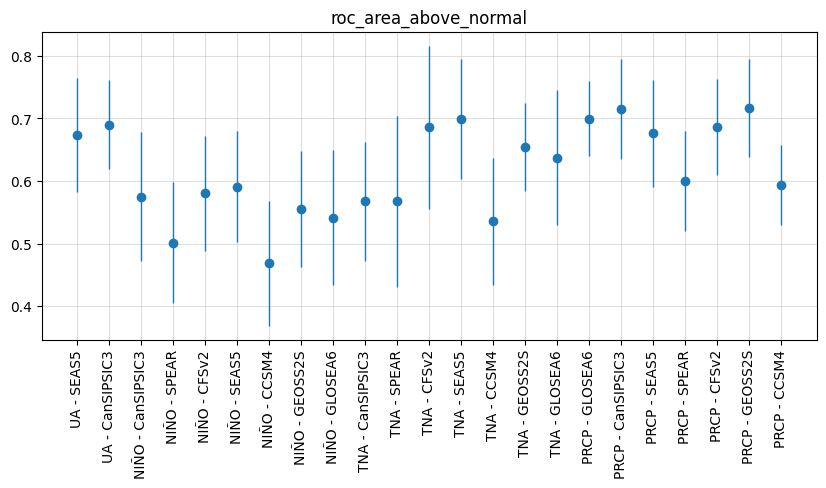

In [322]:
surmjj = dfaggs[(dfaggs.area=="norte") & (dfaggs.periodo=="MJJ")]
for variable in surmjj.variable.unique():
    subdata = surmjj[surmjj.variable == variable]
    xs = (np.arange(0, len(subdata), 1))
    fig = plt.figure(figsize=(10,4))
    plt.title(variable)
    plt.errorbar(xs, subdata["mean"], subdata["std"], lw=1, ls="", marker="o")
    plt.xticks(xs, subdata.apply(lambda c: f"{c.predictor} - {c.model}", axis=1), rotation=90 )
    plt.grid(alpha=0.4)

# Sur, JJA

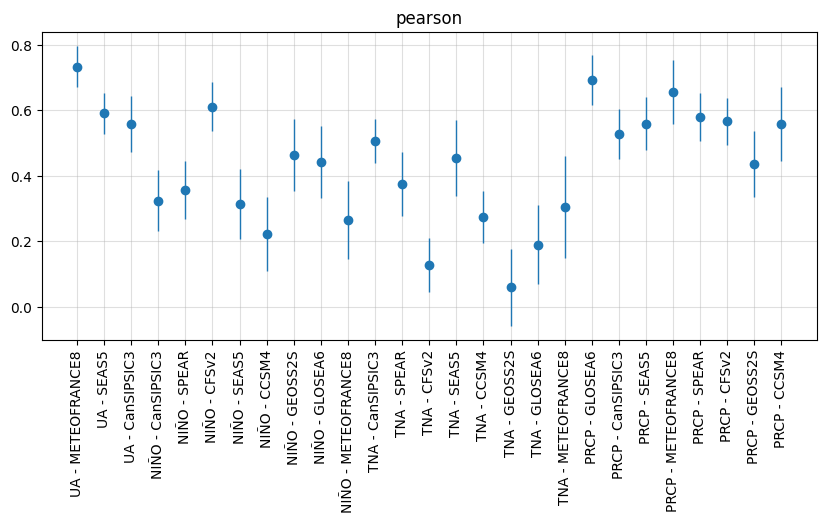

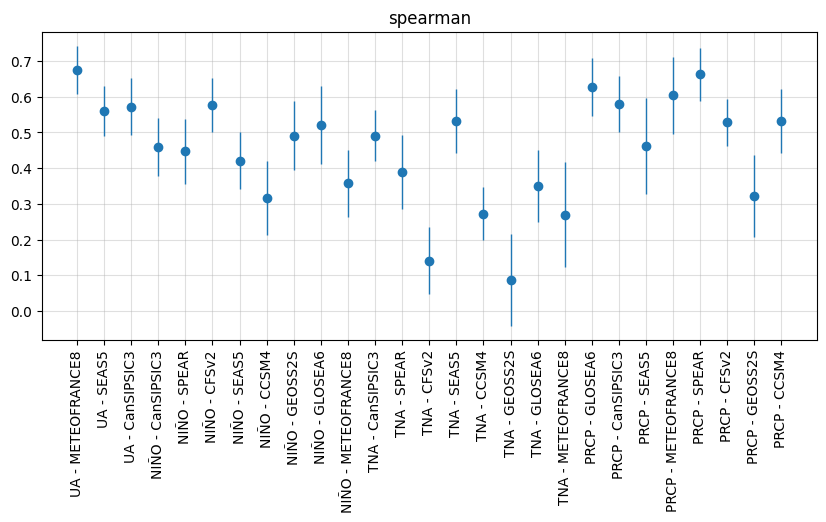

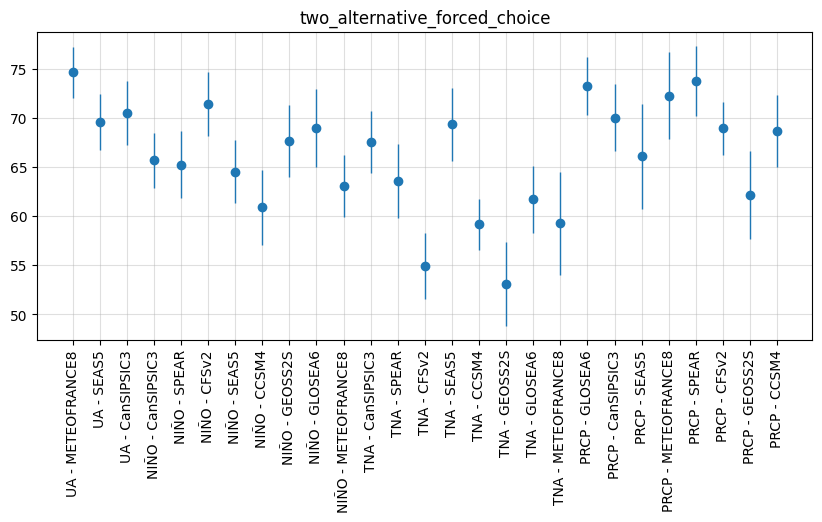

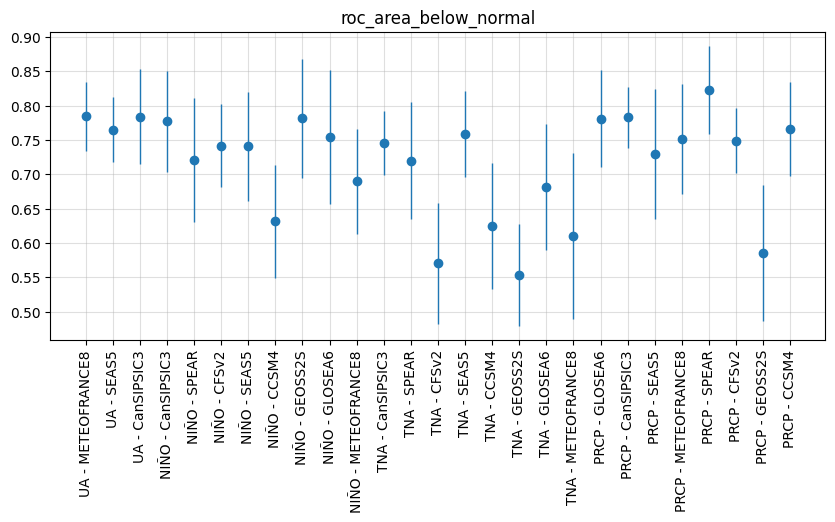

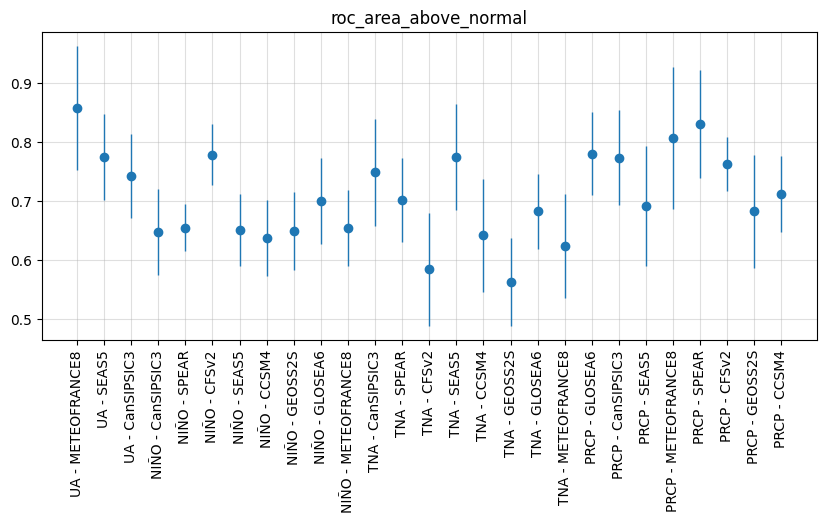

In [325]:
surmjj = dfaggs[(dfaggs.area=="sur") & (dfaggs.periodo=="JJA")]
for variable in surmjj.variable.unique():
    subdata = surmjj[surmjj.variable == variable]
    xs = (np.arange(0, len(subdata), 1))
    fig = plt.figure(figsize=(10,4))
    plt.title(variable)
    plt.errorbar(xs, subdata["mean"], subdata["std"], lw=1, ls="", marker="o")
    plt.xticks(xs, subdata.apply(lambda c: f"{c.predictor} - {c.model}", axis=1), rotation=90 )
    plt.grid(alpha=0.4)

# Central, JJA

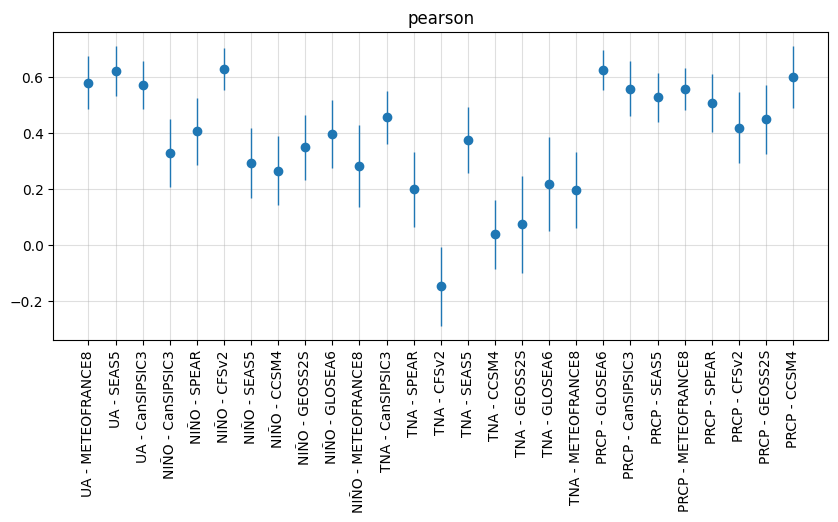

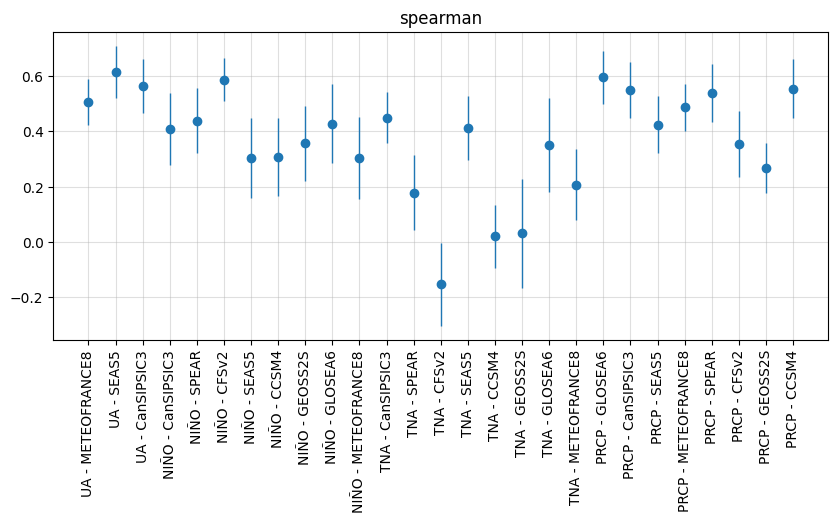

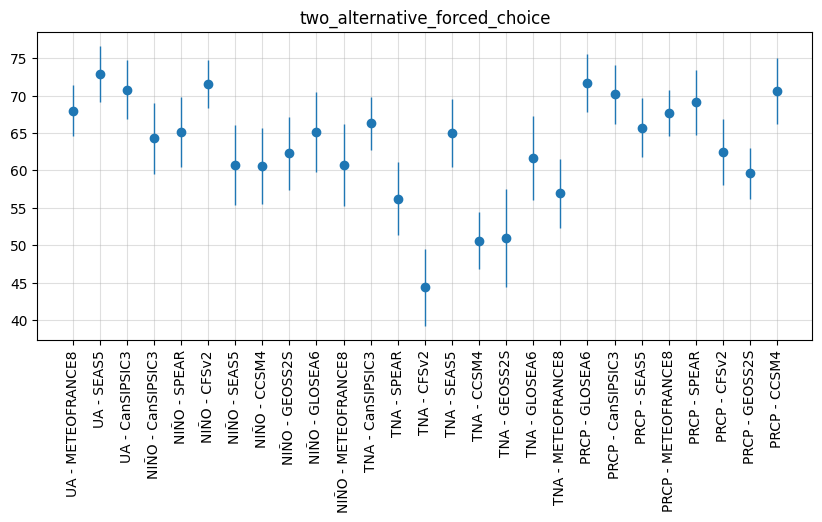

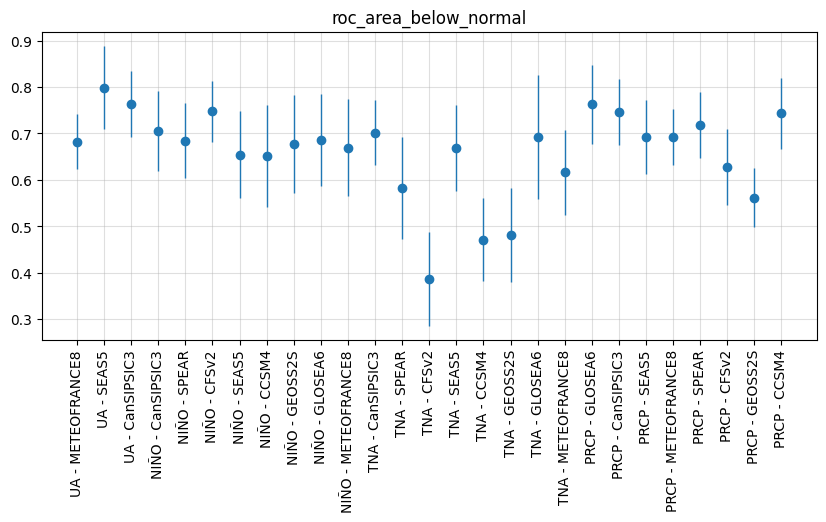

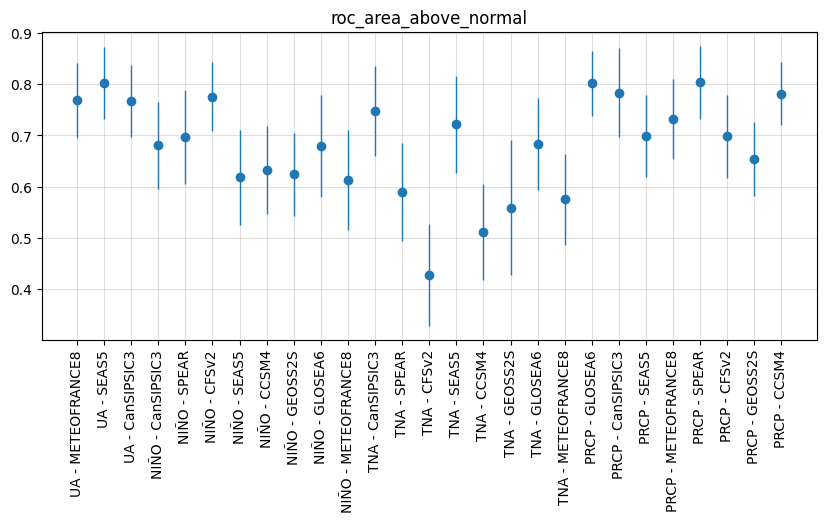

In [326]:
surmjj = dfaggs[(dfaggs.area=="central") & (dfaggs.periodo=="JJA")]
for variable in surmjj.variable.unique():
    subdata = surmjj[surmjj.variable == variable]
    xs = (np.arange(0, len(subdata), 1))
    
    fig = plt.figure(figsize=(10,4))
    plt.title(variable)
    plt.errorbar(xs, subdata["mean"], subdata["std"], lw=1, ls="", marker="o")
    plt.xticks(xs, subdata.apply(lambda c: f"{c.predictor} - {c.model}", axis=1), rotation=90 )
    plt.grid(alpha=0.4)

# Norte, JJA

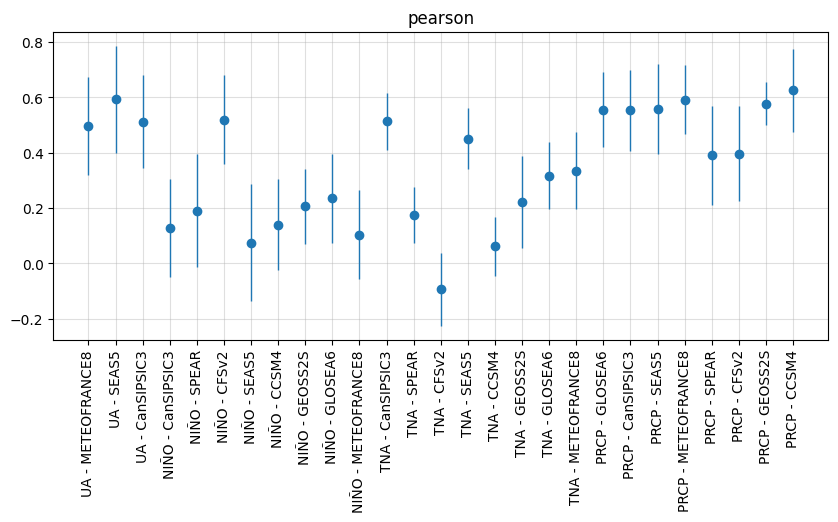

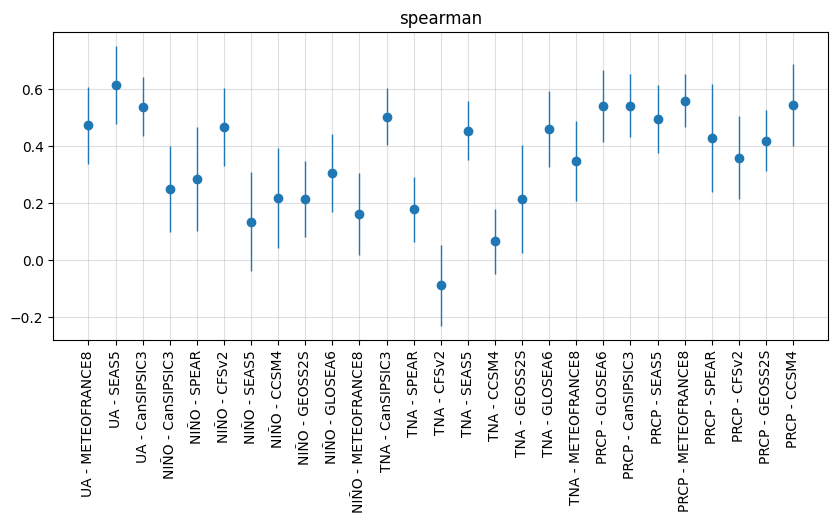

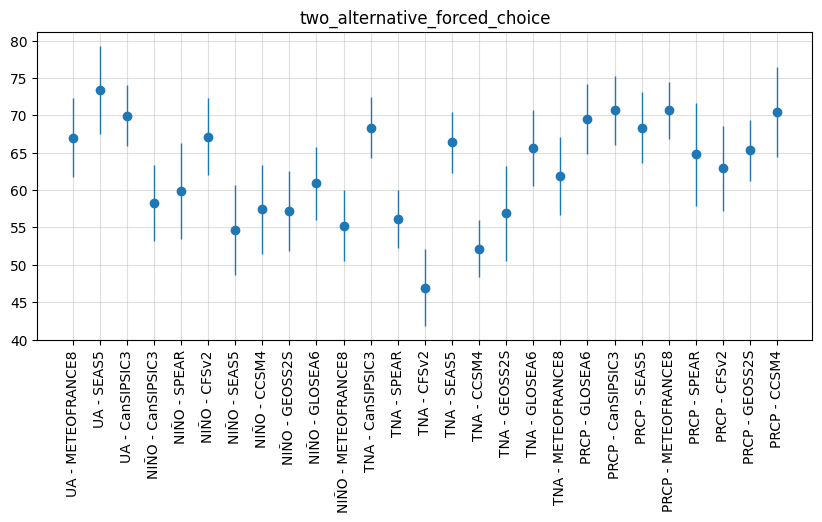

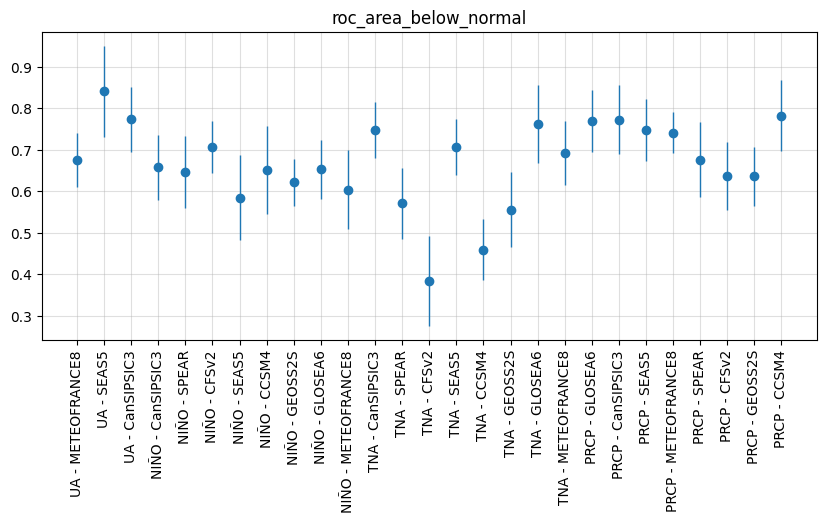

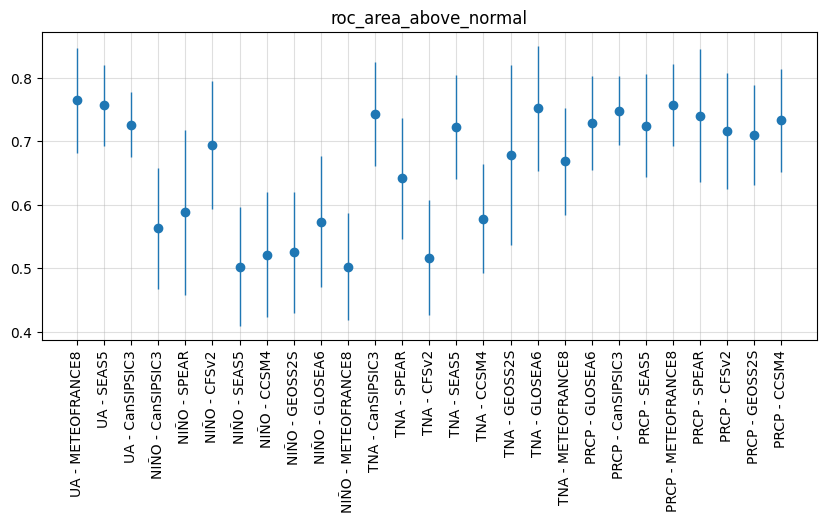

In [327]:
surmjj = dfaggs[(dfaggs.area=="norte") & (dfaggs.periodo=="JJA")]
for variable in surmjj.variable.unique():
    subdata = surmjj[surmjj.variable == variable]
    xs = (np.arange(0, len(subdata), 1))
    fig = plt.figure(figsize=(10,4))
    plt.title(variable)
    plt.errorbar(xs, subdata["mean"], subdata["std"], lw=1, ls="", marker="o")
    plt.xticks(xs, subdata.apply(lambda c: f"{c.predictor} - {c.model}", axis=1), rotation=90 )
    plt.grid(alpha=0.4)

# Sur, JAS

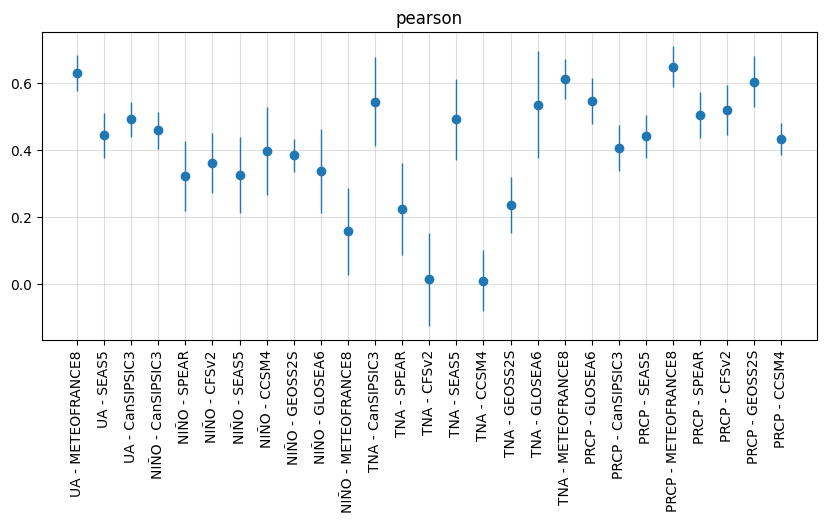

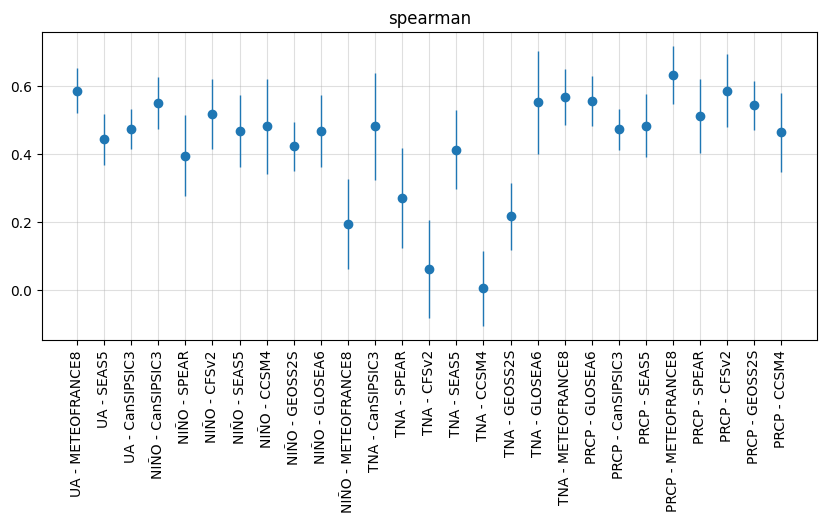

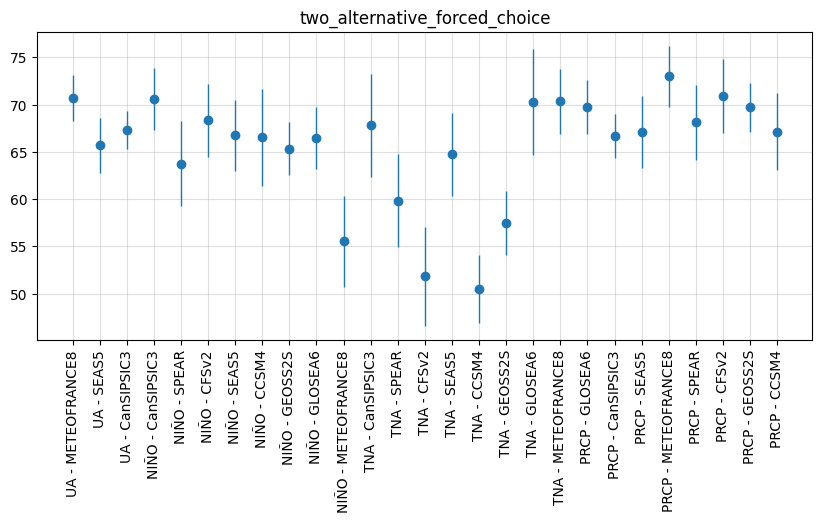

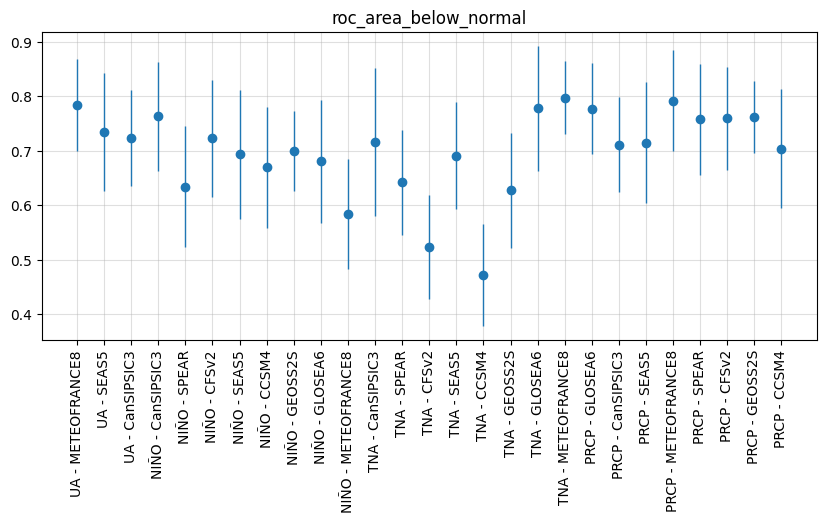

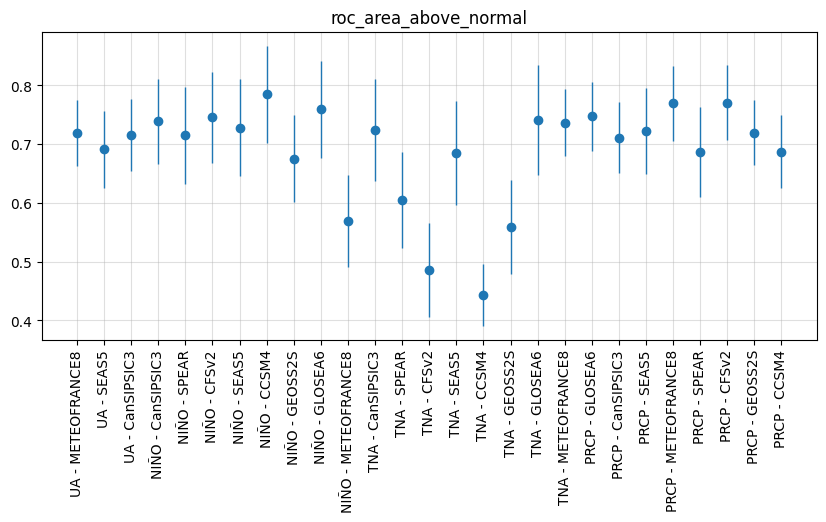

In [328]:
surmjj = dfaggs[(dfaggs.area=="sur") & (dfaggs.periodo=="JAS")]
for variable in surmjj.variable.unique():
    subdata = surmjj[surmjj.variable == variable]
    xs = (np.arange(0, len(subdata), 1))
    fig = plt.figure(figsize=(10,4))
    plt.title(variable)
    plt.errorbar(xs, subdata["mean"], subdata["std"], lw=1, ls="", marker="o")
    plt.xticks(xs, subdata.apply(lambda c: f"{c.predictor} - {c.model}", axis=1), rotation=90 )
    plt.grid(alpha=0.4)

# Central, JAS

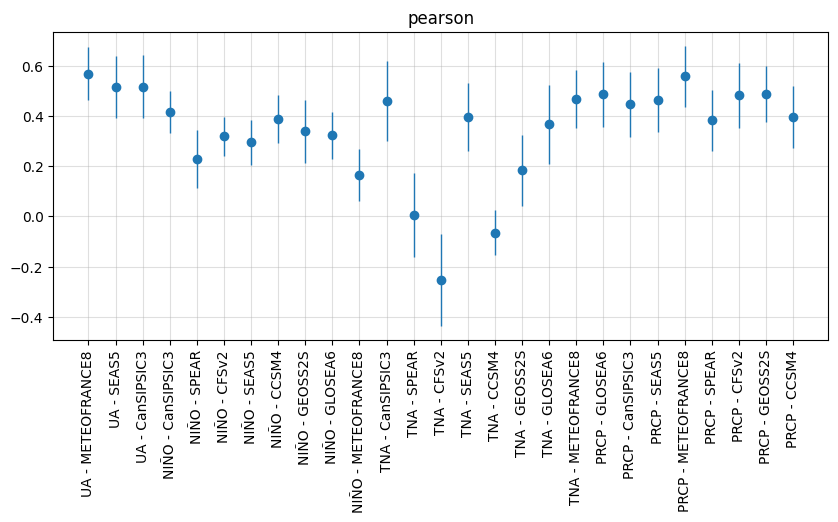

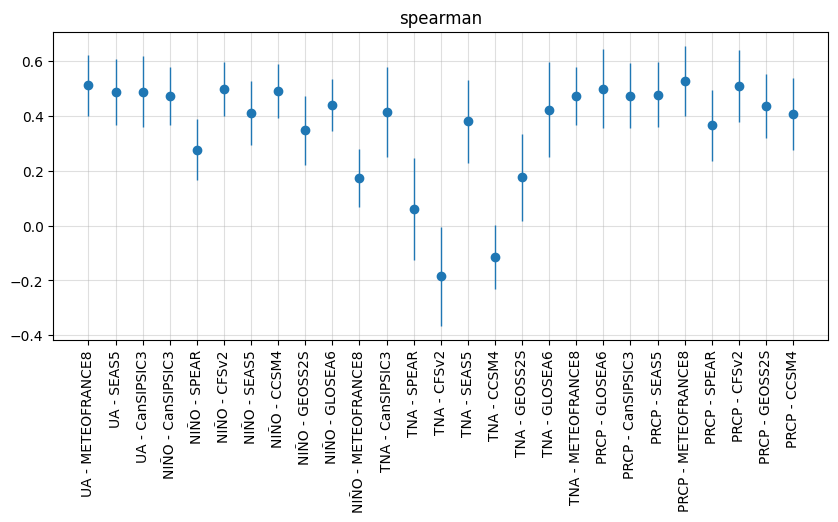

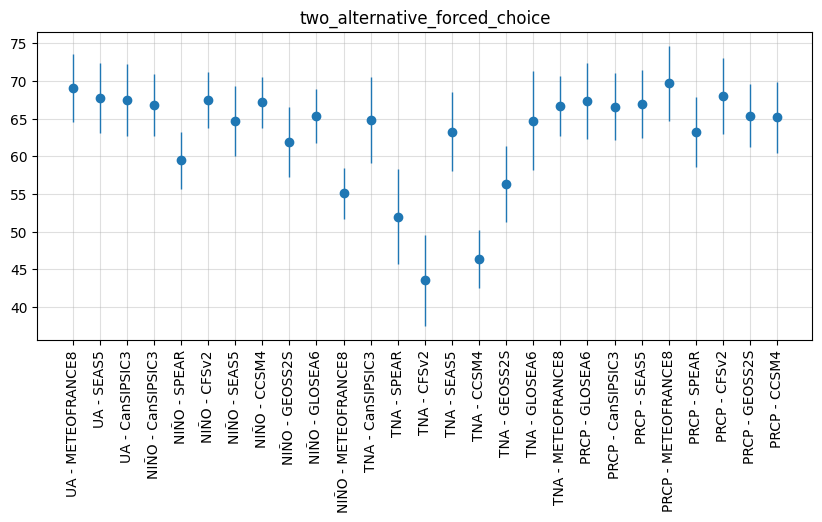

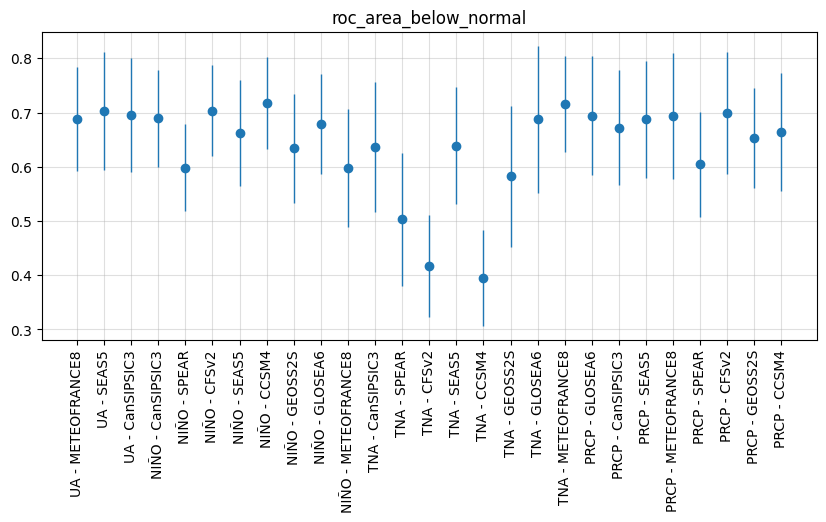

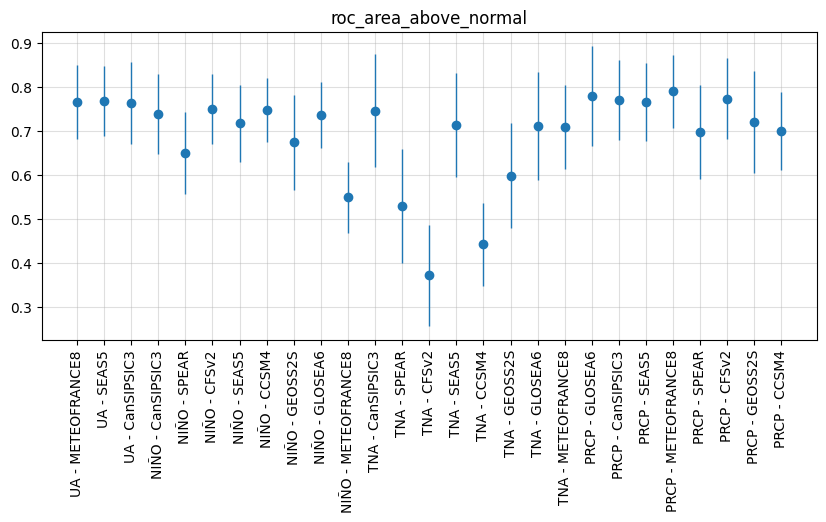

In [329]:
surmjj = dfaggs[(dfaggs.area=="central") & (dfaggs.periodo=="JAS")]
for variable in surmjj.variable.unique():
    subdata = surmjj[surmjj.variable == variable]
    xs = (np.arange(0, len(subdata), 1))
    
    fig = plt.figure(figsize=(10,4))
    plt.title(variable)
    plt.errorbar(xs, subdata["mean"], subdata["std"], lw=1, ls="", marker="o")
    plt.xticks(xs, subdata.apply(lambda c: f"{c.predictor} - {c.model}", axis=1), rotation=90 )
    plt.grid(alpha=0.4)

# Norte, JAS

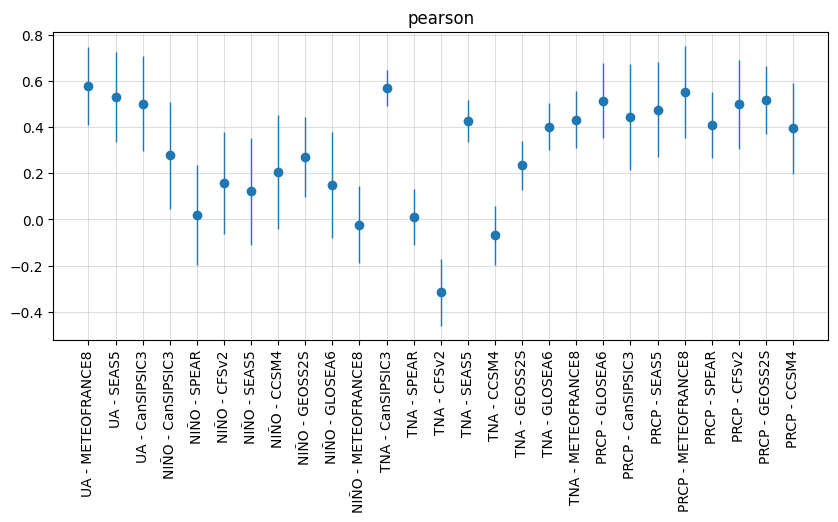

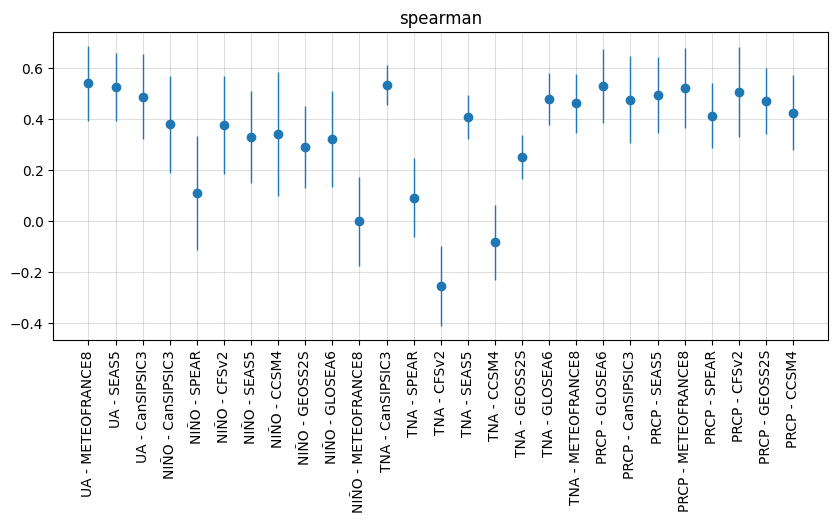

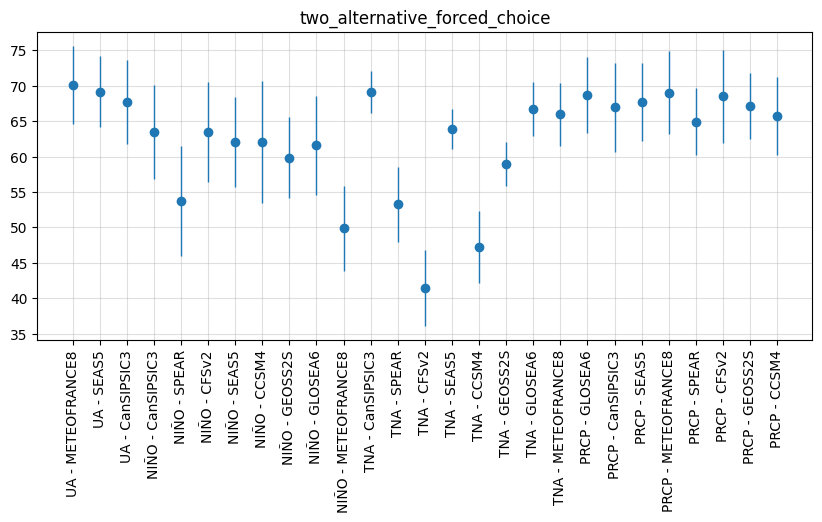

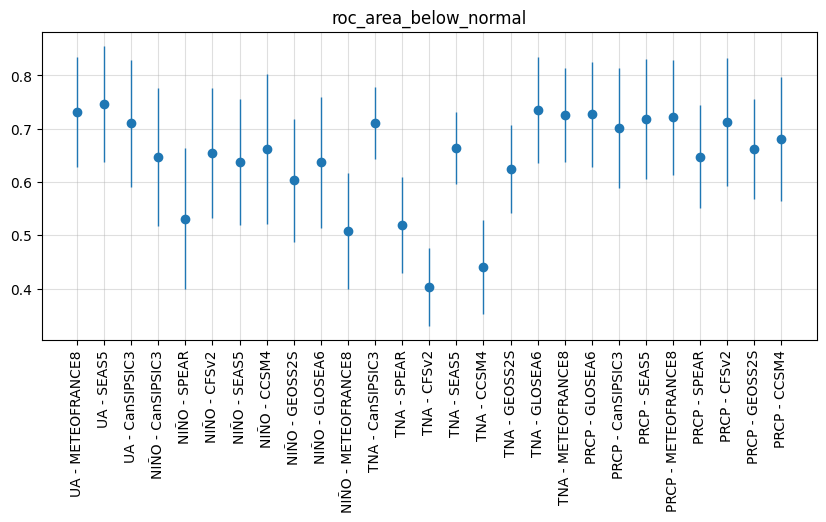

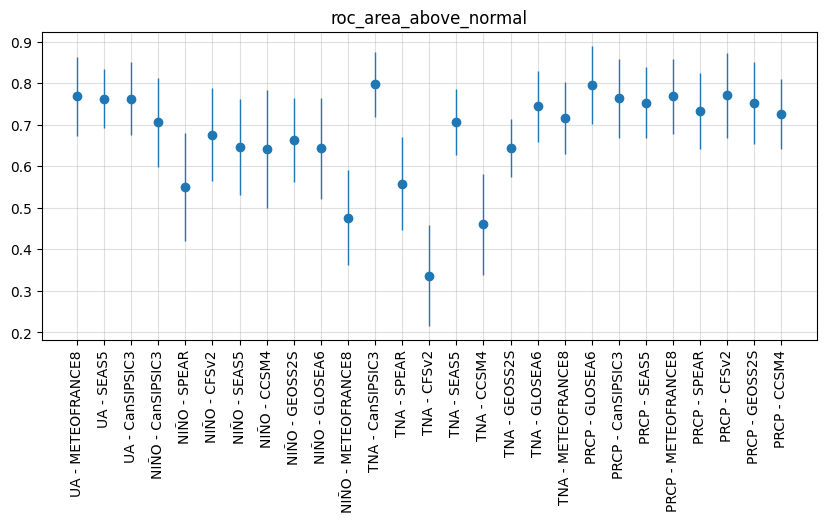

In [330]:
surmjj = dfaggs[(dfaggs.area=="norte") & (dfaggs.periodo=="JAS")]
for variable in surmjj.variable.unique():
    subdata = surmjj[surmjj.variable == variable]
    xs = (np.arange(0, len(subdata), 1))
    fig = plt.figure(figsize=(10,4))
    plt.title(variable)
    plt.errorbar(xs, subdata["mean"], subdata["std"], lw=1, ls="", marker="o")
    plt.xticks(xs, subdata.apply(lambda c: f"{c.predictor} - {c.model}", axis=1), rotation=90 )
    plt.grid(alpha=0.4)

In [ ]:
a